# Exploring the Chance that the Chiefs Three-Peat and Win the SuperBowl

## Introduction:

Over the last two years, the Chiefs have dominated football, winning the two most recent Superbowls and making a name for themselves as one of the greatest football teams since the Patriots who were led by Tom Brady. Patrick Mahomes, in these recent years, has been making a huge name for himself by following a similar dynasty-like path. So with the Chiefs starting the season undefeated, we wanted to predict the chance that they win the superbowl and become the only NFL team in history to win three superbowls in a row. If they are able to achieve this feat, the Chiefs, along with Patrick Mahomes, will be in the conversation of being the greatest team/quarterback of all time. 

We do this by taking into account offensive and defensive stats, as well as nfl elo, a statistic measuring team strength. We use the data from multiple data sources to gather this information and ultimately come up with a model that puts into perspective the probability of a super bowl win for the Chiefs.

Team Members:

Andy Granovski
Richard Mukam Jr.
Justin Zhai

Andy Granovski Contribution:

I preprocessed much of the past nfl_elo data, making the hypothesis tests necessary to provide information to justify the connection between the elo stat and a team winning. I then heavily contributed to building, tuning, and optimizing the logistic regression model that was trained on previous team data and used on current team data for predicting superbowl win probabilities. 

Richard Mukam Jr. Contribution:

Justin Zhai Contribution:

I developed the hypothesis testing to determine what parameters in the datasets were statistically significant between super-bowl caliber and non super-bowl caliber teams. I also produced visualizations for the intermediate hypothesis testing and final results. I edited existing visualizations to be more appropriate. I worked on preprocessing and extrapolating the data incomplete data that was fed into the ML model. Lastly, I worked on writing the final conclusions of the model.

## Data Collection

For our data, we utilized a multitude of sources:

- For current team stats and elo/power rankings we used: https://www.nfeloapp.com/nfl-power-ratings/

- For current qb stats and elo/power rankings we used: https://www.nfeloapp.com/qb-rankings/

- For historical data regarding the teams, for the range of 2003-2023, we used: https://www.kaggle.com/datasets/nickcantalupa/nfl-team-data-2003-2023

Citation : Cantalupa, Nick. “NFL Team Data 2003-2023.” Kaggle, 25 Jan. 2024, https://www.kaggle.com/datasets/nickcantalupa/nfl-team-data-2003-2023.

### Imports:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score

plt.style.use('fivethirtyeight')

We started by taking the historical NFL Elo dataset and preprocessing the data. This is an integral part of the process from which we derive useful data and clean our existing data so as to make it completely usable and avoid any ambiguous issues with the dataset.

Here we dropped unnecessary columns, made sure to filter out all games prior to the SuperBowl's introduction, made sure to filter games to only include those during the NFL season, and created bins for elo differences between teams and their respective quarterbacks as well as a favored column to denote the favored team pre-matchup, based on elo.

In [2]:
# Create a dictionary of team_name_mapping as a way to convert between datasets which use
# abbreviations and those that don't.
team_name_mapping = {
    'ARI': 'Arizona Cardinals',
    'ATL': 'Atlanta Falcons',
    'BAL': 'Baltimore Ravens',
    'BUF': 'Buffalo Bills',
    'CAR': 'Carolina Panthers',
    'CHI': 'Chicago Bears',
    'CIN': 'Cincinnati Bengals',
    'CLE': 'Cleveland Browns',
    'DAL': 'Dallas Cowboys',
    'DEN': 'Denver Broncos',
    'DET': 'Detroit Lions',
    'GB': 'Green Bay Packers',
    'HOU': 'Houston Texans',
    'IND': 'Indianapolis Colts',
    'JAX': 'Jacksonville Jaguars',
    'KC': 'Kansas City Chiefs',
    'LAC': 'Los Angeles Chargers',
    'LAR': 'Los Angeles Rams',
    'MIA': 'Miami Dolphins',
    'MIN': 'Minnesota Vikings',
    'NE': 'New England Patriots',
    'NO': 'New Orleans Saints',
    'NYG': 'New York Giants',
    'NYJ': 'New York Jets',
    'OAK': 'Oakland Raiders',
    'PHI': 'Philadelphia Eagles',
    'PIT': 'Pittsburgh Steelers',
    'SEA': 'Seattle Seahawks',
    'SF': 'San Francisco 49ers',
    'TB': 'Tampa Bay Buccaneers',
    'TEN': 'Tennessee Titans',
    'WAS': 'Washington Commanders'
}


In [3]:
# Load the NFL Elo dataset into a DataFrame
nfl_elo_df = pd.read_csv('nfl_elo.csv')

# Defining columns which will not be need for our analysis (many of which provide post game evaluation)
columns_to_drop = [
    'qb1_value_pre', 'qb2_value_pre', 'qb1_adj', 'qb2_adj',
    'elo1_post', 'elo2_post', 'qb1_game_value', 'qb2_game_value',
    'qb1_value_post', 'qb2_value_post', 'qbelo1_post', 'qbelo2_post'
]

# Remove the unnecessary columns from the DataFrame
nfl_elo_df = nfl_elo_df.drop(columns=columns_to_drop)

# Convert the 'date' column to a datetime object for easier filtering and manipulation
nfl_elo_df['date'] = pd.to_datetime(nfl_elo_df['date'])

# Add a column indicating the winner of the game based on the scores
nfl_elo_df['winner'] = np.where(nfl_elo_df['score1'] > nfl_elo_df['score2'], nfl_elo_df['team1'], nfl_elo_df['team2'])

# Filter the DataFrame to include games from 1970 and onwards, the year from which the SuperBowl was introduced
nfl_elo_df = nfl_elo_df[nfl_elo_df['date'].dt.year >= 1970]

# Further filter the games to include only those played in September through February (separating stats into that of an NFL season)
nfl_elo_df = nfl_elo_df[(nfl_elo_df['date'].dt.month >= 9) | (nfl_elo_df['date'].dt.month <= 2)]

# Add a column for the team that was favored to win based on the Elo probabilities (per game)
nfl_elo_df['favored_team'] = np.where(nfl_elo_df['elo_prob1'] > nfl_elo_df['elo_prob2'], nfl_elo_df['team1'], nfl_elo_df['team2'])

# Add a column indicating whether the favored team won the game
nfl_elo_df['favored_team_won'] = np.where(nfl_elo_df['favored_team'] == nfl_elo_df['winner'], 'Won', 'Lost')

# Add a column for the team whose quarterback was favored based on QB Elo probabilities
nfl_elo_df['favored_qb'] = np.where(nfl_elo_df['qbelo_prob1'] > nfl_elo_df['qbelo_prob2'], nfl_elo_df['team1'], nfl_elo_df['team2'])

# Add a column indicating whether the team with the favored quarterback won the game
nfl_elo_df['favored_qb_won'] = np.where(nfl_elo_df['favored_team'] == nfl_elo_df['winner'], 'Won', 'Lost')

# Calculate the absolute difference in Elo ratings between the two teams
nfl_elo_df['team_elo_difference'] = abs(nfl_elo_df['elo1_pre'] - nfl_elo_df['elo2_pre'])

# Calculate the absolute difference in QB Elo ratings between the two quarterbacks
nfl_elo_df['qb_elo_difference'] = abs(nfl_elo_df['qbelo1_pre'] - nfl_elo_df['qbelo2_pre'])

# Categorize the team Elo differences into bins (Low, Medium, High) using quantiles
nfl_elo_df['team_elo_difference_bins'] = pd.qcut(nfl_elo_df['team_elo_difference'], q=3, labels=['Low', 'Medium', 'High'])

# Categorize the QB Elo differences into bins (Low, Medium, High) using quantiles
nfl_elo_df['qb_elo_difference_bins'] = pd.qcut(nfl_elo_df['qb_elo_difference'], q=3, labels=['Low', 'Medium', 'High'])

# Add a column for the Elo rating of the favored team
nfl_elo_df['favored_team_elo'] = np.where(nfl_elo_df['favored_team'] == nfl_elo_df['team1'], nfl_elo_df['elo1_pre'], nfl_elo_df['elo2_pre'])

# Add a column for the winning probability of the favored team based on Elo ratings
nfl_elo_df['favored_team_elo_prob'] = np.where(nfl_elo_df['favored_team'] == nfl_elo_df['team1'], nfl_elo_df['elo_prob1'], nfl_elo_df['elo_prob2'])

# Mark if game was playoffs or not to separate between regualr season and playoffs
nfl_elo_df['playoff'] = nfl_elo_df['playoff'].apply(lambda x: 0 if pd.isna(x) else 1)

# Eliminate all null values of the importance column by replacing them with 0
nfl_elo_df['importance'] = nfl_elo_df['importance'].fillna(0)

Simple info dump to show the dimensions of our data, the current columns at use, and info regarding the dataset.

In [4]:
print(f"Shape of DataFrame {nfl_elo_df.shape}")
print(f"Columns of DataFrame {nfl_elo_df.columns}")
print(nfl_elo_df.info())

Shape of DataFrame (12819, 32)
Columns of DataFrame Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'qbelo1_pre', 'qbelo2_pre', 'qb1',
       'qb2', 'qbelo_prob1', 'qbelo_prob2', 'score1', 'score2', 'quality',
       'importance', 'total_rating', 'winner', 'favored_team',
       'favored_team_won', 'favored_qb', 'favored_qb_won',
       'team_elo_difference', 'qb_elo_difference', 'team_elo_difference_bins',
       'qb_elo_difference_bins', 'favored_team_elo', 'favored_team_elo_prob'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 12819 entries, 4546 to 17378
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      12819 non-null  datetime64[ns]
 1   season                    12819 non-null  int64         
 2   neutral                   12819 non-null  int64       

## Hypothesis Test 1

Now we test the correlation between a higher elo difference between teams prior to the start of the game and then the outcome of the game. 

Elo is a rating system originally used to calculating the relative strength of players in Chess. It's since be expanded to used as a rating system for video games, sports, and other zero-sum games. You can read more about elo [here](https://en.wikipedia.org/wiki/Elo_rating_system).

HO: The null hypothesis is a lack of correlation between elo difference between teams prior to the game beginning and the favored team winning the game.

HA: The alternative hypothesis is that there is a relationship between the difference in the elos of the teams and the favored team winning.

This test will allow us to understand how effective elo will be in our analysis of a team's winning capabilities. Our alpha that we're testing against is 0.05.

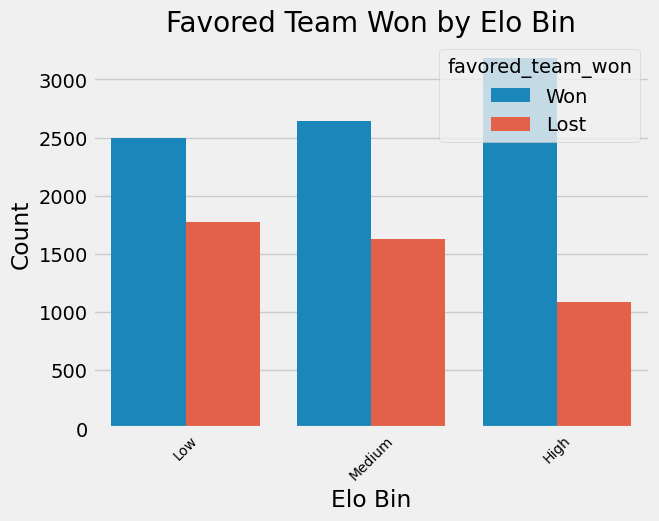

In [5]:
# Creating a plot to visualize our hypothesis test
sns.countplot(x='team_elo_difference_bins', hue='favored_team_won', data=nfl_elo_df)

plt.title('Favored Team Won by Elo Bin')
plt.xlabel('Elo Bin')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=10)
plt.show()

In [6]:
contingency_table_season = pd.crosstab(nfl_elo_df['team_elo_difference_bins'], nfl_elo_df['favored_team_won'])
contingency_table_season
chi2 = stats.chi2_contingency(contingency_table_season)
print(f"P-Value: {chi2.pvalue}")

P-Value: 7.701043280258464e-59


From this p-value (which is less than 0.05) we can see that there is therefore a relation between a team having a greater elo difference and the favored team winning, so we reject the null hypothesis and accept the alternative that difference in elo and favored team winning have a relationship.

And now we extend the same ideas to the qb elos to determine if there's a correlation between a team winning based on their qb's elo rating prior to the game. Null hypothesis relates to no relation while an alternative hypothesis states there is a correlation.

HO: The null hypothesis is a lack of correlation between elo difference between qbs prior to the game beginning and the favored team winning the game.

HA: The alternative hypothesis is that there is a relationship between the difference in the elos of the qbs and the favored team winning.

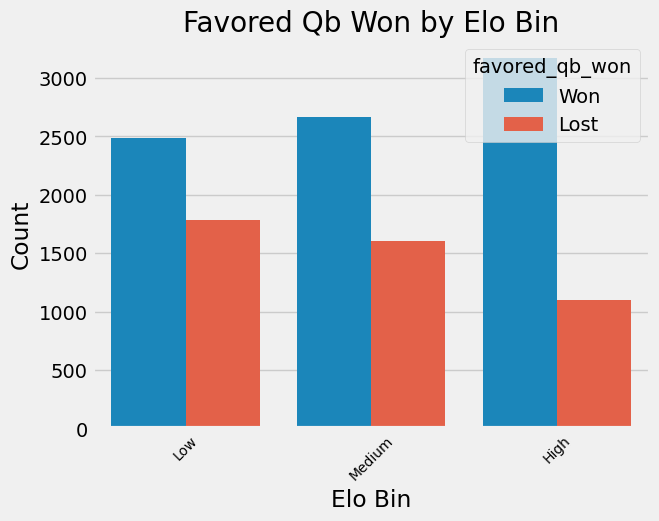

In [7]:
# Creating a plot to visualize our hypothesis test
sns.countplot(x='qb_elo_difference_bins', hue='favored_qb_won', data=nfl_elo_df)

plt.title('Favored Qb Won by Elo Bin')
plt.xlabel('Elo Bin')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=10)
plt.show()

In [8]:
contingency_table_playoff = pd.crosstab(nfl_elo_df['qb_elo_difference_bins'], nfl_elo_df['favored_qb_won'])
contingency_table_playoff
chi2 = stats.chi2_contingency(contingency_table_playoff)
print(f"P-Value: {chi2.pvalue}")

P-Value: 8.729081314786216e-57


Similarly, we see here that a greater elo difference for the favored quarterback and the favored quarterback's team winning belong to the same distribution. The p-value is less than 0.05 and thus we reject the null hypothesis and accept the alternative hypothesis.

## Hypothesis Test 2

Now, we take a look at past performances by Kansas City and determine what metrics seperates a super bowl caliber team versus a regular team. We define super bowl caliber team as a team that at least played in the conference finals. 
We first import the data and clean it 

In [9]:
team_data = pd.read_csv('team_data.csv')

#take modern data of when the league was at least 28 teams
team_data = team_data[(team_data['out of'] == 32) & (team_data['Year'] < 2024)]
team_data['winning_pct'] = team_data['W'] / (team_data['W'] + team_data['L'])
team_data['Games'] = team_data['W'] + team_data['L'] + team_data['T']
team_data.fillna({'Playoffs': 'Did not make Playoffs'}, inplace=True)
#normalize data to per game data to allow for comparison between seasons of different lengths
for data in ['PF', 'PA', 'PD']:
    team_data[data] = team_data[data] / team_data['Games']

#seperate data of superbowl caliber teams and non superbowl caliber teams
sb_data = team_data[team_data['Playoffs'].str.contains('SB') | team_data['Playoffs'].str.contains('Conf')]
non_sb_data = team_data[~team_data['Playoffs'].str.contains('SB') & ~team_data['Playoffs'].str.contains('Conf')]
sb_data

,Year,Lg,Tm,W,L,T,Div. Finish,Playoffs,PF,PA,...,Pts±,Yds±,out of,MoV,SoS,SRS,OSRS,DSRS,winning_pct,Games
1,2023,NFL,Kansas City Chiefs*,11,6,0,1st of 4,Won SB,21.823529,17.294118,...,6,7,32,4.5,-0.8,3.7,-0.6,4.4,0.647059,17
2,2022,NFL,Kansas City Chiefs*,14,3,0,1st of 4,Won SB,29.176471,21.705882,...,4,2,32,7.5,-1.2,6.2,6.8,-0.6,0.823529,17
3,2021,NFL,Kansas City Chiefs*,12,5,0,1st of 4,Lost Conf,28.235294,21.411765,...,5,11,32,6.8,0.6,7.4,5.4,2.0,0.705882,17
4,2020,NFL,Kansas City Chiefs*,14,2,0,1st of 4,Lost SB,29.562500,22.625000,...,6,3,32,6.9,-0.1,6.8,4.5,2.3,0.875000,16
5,2019,NFL,Kansas City Chiefs*,12,4,0,1st of 4,Won SB,28.187500,19.250000,...,4,10,32,8.9,0.2,9.1,6.2,2.9,0.750000,16
6,2018,NFL,Kansas City Chiefs*,12,4,0,1st of 4,Lost Conf,35.312500,26.312500,...,2,11,32,9.0,-0.1,8.9,12.6,-3.8,0.750000,16


In [10]:
#use t-tests to find which stats indicate a statistical different between superbowl winning teams and non superbowl winning teams
stats_list = ['winning_pct', 'PF', 'PA', 'PD']
for stat in stats_list:
    print(stat, stats.ttest_ind(sb_data[stat], non_sb_data[stat]).pvalue)

#use Wilcoxon rank sum for rank data
rank_list = ['OffPts', 'OffYds', 'DefPts', 'DefYds']
for stat in rank_list:
    print(stat, stats.ranksums(sb_data[stat], non_sb_data[stat]).pvalue)

winning_pct 0.011542131111451083
PF 0.026462367288040155
PA 0.7524148665938686
PD 0.035810790552714314
OffPts 0.0552702806762724
OffYds 0.018320735421941195
DefPts 0.25317348676295626
DefYds 0.460994786425578


From this set of data we can see winning percentage, points for, points differential, offensive yards per game rank, and offensive points per game (almost 0.05 significant) is what is statistically different between a super bowl caliber Kansas City team versus a regular Kansas City team

Next, We plot some of the data to see visually how the super bowl caliber teams compare. The box and whiskers are plotted using non-sb team data. and the data points are plotted on top of the box and whisker to see where they fall in comparison to the mean. 

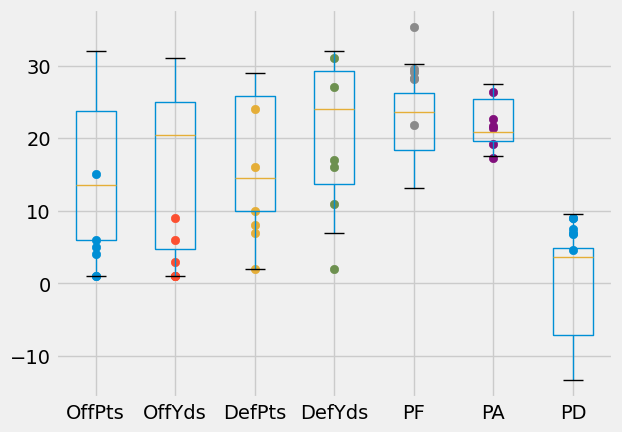

In [11]:
percentage_stats = ['OffPts', 'OffYds', 'DefPts', 'DefYds', 'PF', 'PA', 'PD']
non_sb_data.boxplot(column= percentage_stats)

for i, stat in enumerate(percentage_stats, start=1):
    y = sb_data[stat]
    x = [i] * len(y)
    plt.scatter(x, y)

## Hypothesis Test 3

Now, we also want to take a look at the winning percentages of teams over the years and attempt to identify a correlation between the team's with the highest winning percentages per NFL season and the eventual Super Bowl Champions of said season. By historical data and observations, the team with the best record have a greater likelihood of winner the Super Bowl, and currently (as of Octoer 22, 2024) the Kansas City Chiefs have the best winning percentage in the NFL with a figure of 1.000. They're the only team 1.000, and are currently 6-0. The ultimate goal of our problem statement is to prove that the Kansas City Chiefs will win the 2024-2025 Super Bowl title, and these observations are important to delve into. To test this theory, hypotheses were made.

Null Hypothesis: There is no association between having the highest winning percentage and winning the Super Bowl.

Alternative Hypothesis: There is an association between having the highest winning percentage and winning the Super Bowl.

The sets of data that we'll be looking at is the team, their winning percentage, the season, and the superbowl champions of that season. To conduct this hypothesis, we'll be employing the Chi-Square Test.

In [12]:
# this data displays all of the superbowl winners from 1967 - 2024.
superbowl_winners = pd.read_csv("superbowl_winners.csv")
# this data primarily to retrieve the win percentages of each team.
team_statistics = pd.read_csv("team_stats_2003_2023.csv")
highest_win_perc = team_statistics.loc[team_statistics.groupby('year')['win_loss_perc'].idxmax(), ['year', 'team', 'win_loss_perc']]
# merging to the above data frame the winners from each season
highest_win_perc
win_perc_sb_winner = highest_win_perc.merge(superbowl_winners, left_on=['year'], right_on=['Year'], how='left')
win_perc_sb_winner = win_perc_sb_winner.rename(columns={'Team': 'Superbowl Champions'})
win_perc_sb_winner = win_perc_sb_winner.rename(columns={'team': 'Highest Win%'})
win_perc_sb_winner = win_perc_sb_winner.rename(columns={'win_loss_perc': 'W/L%'})

win_perc_sb_winner

,year,Highest Win%,W/L%,Year,Superbowl Champions
0,2003,New England Patriots,0.875,2003,Tampa Bay Buccaneers
1,2004,Pittsburgh Steelers,0.938,2004,New England Patriots
2,2005,Indianapolis Colts,0.875,2005,New England Patriots
3,2006,San Diego Chargers,0.875,2006,Pittsburgh Steelers
4,2007,New England Patriots,1.000,2007,Indianapolis Colts
5,2008,Tennessee Titans,0.813,2008,New York Giants
6,2009,Indianapolis Colts,0.875,2009,Pittsburgh Steelers
7,2010,New England Patriots,0.875,2010,New Orleans Saints
8,2011,Green Bay Packers,0.938,2011,Green Bay Packers
9,2012,Denver Broncos,0.813,2012,New York Giants


A new series is created to represent data frames that both had the highest winning percentage and also won the Super Bowl in the same season.

In [13]:
win_perc_sb_winner['Won Super Bowl'] = win_perc_sb_winner['Superbowl Champions'] == win_perc_sb_winner['Highest Win%']
contingency_table = pd.crosstab(index=win_perc_sb_winner['Highest Win%'], columns=win_perc_sb_winner['Won Super Bowl'])
_, p_val, _, _ = stats.chi2_contingency(contingency_table)
p_val

0.8129240984904025

Now, we have found our p-value which is 0.8129. Now, with our α = 0.05, we can confidently fail to reject our null hypothesis. Thus, we we can strongly make the statement that there is no association between having the highest winning percentage and winning the Super Bowl. This is especially important to note in our continual case of explaining why the Chiefs will win the Superbowl given that they currently have the best record in the NFL.

In [14]:
# Add a 'year' column to the DataFrame based on the date. 
# If the month is September or later, use the same year; otherwise, subtract one year (to align with the NFL season structure).
nfl_elo_df['year'] = nfl_elo_df['date'].apply(lambda x: x.year if x.month >= 9 else x.year - 1)

# Combine team Elo ratings for both Team 1 and Team 2 into a single DataFrame, with consistent column names for team and Elo.
# This makes it easier to compute statistics across all teams.
team_elo_combined = pd.concat([
    nfl_elo_df[['year', 'team1', 'elo1_pre']].rename(columns={'team1': 'team', 'elo1_pre': 'elo'}),
    nfl_elo_df[['year', 'team2', 'elo2_pre']].rename(columns={'team2': 'team', 'elo2_pre': 'elo'})
])

# Calculate the average Elo rating per team for each season.
average_elo_per_season = team_elo_combined.groupby(['year', 'team'])['elo'].mean().reset_index()

# Rename the 'elo' column to 'average_elo' for better clarity in this dataset.
average_elo_per_season.rename(columns={'elo': 'average_elo'}, inplace=True)

# Define a function to map team names to their correct names for specific time periods, 
# handling cases where teams have moved or rebranded. This is using the earlier defined dict.
def map_team_names(row):
    if row['year'] < 2017 and row['team'] == 'LAC':
        return 'San Diego Chargers'  # Before 2017, the Chargers were based in San Diego.
    elif row['year'] < 2016 and row['team'] == 'LAR':
        return 'St. Louis Rams'  # Before 2016, the Rams were based in St. Louis.
    elif row['year'] >= 2020 and row['team'] == 'OAK':
        return 'Las Vegas Raiders'  # Starting in 2020, the Raiders moved to Las Vegas.
    elif row['year'] <= 2019 and row['team'] == 'WSH':
        return 'Washington Redskins'  # Until 2019, the Washington team was known as the Redskins.
    elif 2020 <= row['year'] <= 2021 and row['team'] == 'WSH':
        return 'Washington Football Team'  # During 2020-2021, the team was known as the Washington Football Team.
    elif row['year'] >= 2022 and row['team'] == 'WSH':
        return 'Washington Commanders'  # From 2022 onwards, the team was rebranded as the Commanders.
    return team_name_mapping.get(row['team'], row['team'])  # Use a pre-defined mapping for other team names.

# Apply the team name mapping function to the 'team' column in the average Elo DataFrame.
average_elo_per_season['team'] = average_elo_per_season.apply(map_team_names, axis=1)

# Merge the average Elo ratings into the main team statistics DataFrame based on year and team.
team_statistics = team_statistics.merge(
    average_elo_per_season, how='left', on=['year', 'team']
)

# Filter the team statistics DataFrame to exclude data for the year 2023 or later because historic
# elo data was only tracked by ABC (the source) up until 2022 so we unfortunately cannot obtain elo
# values for 2023.
team_statistics = team_statistics[team_statistics['year'] < 2023]


In [15]:
# Create a column denoting if the team won the superbowl and initially set all to 0.
team_statistics['Won_SB'] = 0

# Adjusted year since our years were marked as those when the superbowl took place while the year
# of the season is actually the year prior due to the start being in September
superbowl_winners['adjusted_year'] = superbowl_winners['Year'] - 1

# Iterate to find the year and team that won the superbowl that year and mark 1 in the appropriate
# cells.
for _, row in superbowl_winners.iterrows():
    year = row['adjusted_year']
    team = row['Team']
    
    team_statistics.loc[(team_statistics['year'] == year) & (team_statistics['team'] == team), 'Won_SB'] = 1


In [16]:
# Drop the ties column as its unnecessary for our analysis
team_statistics.drop(columns=['ties'], inplace=True)

# Fill the average 'mov' column cells that are empty with the average of the mov value
team_statistics['mov'] = team_statistics['mov'].fillna(team_statistics['mov'].mean())

In [17]:
from sklearn.model_selection import train_test_split

chiefs_data = nfl_elo_df[(nfl_elo_df['team1'] == 'KC') | (nfl_elo_df['team2'] == 'KC')]
chiefs_data = chiefs_data[chiefs_data['season'] >= 2018]

chiefs_data['chiefs_win'] = (
    ((chiefs_data['team1'] == 'KC') & (chiefs_data['winner'] == chiefs_data['team1'])) |
    ((chiefs_data['team2'] == 'KC') & (chiefs_data['winner'] == chiefs_data['team2']))
).astype(int)

chiefs_data['chiefs_elo_pre'] = chiefs_data.apply(
    lambda row: row['elo1_pre'] if row['team1'] == 'KC' else row['elo2_pre'], axis=1
)
chiefs_data['opp_elo_pre'] = chiefs_data.apply(
    lambda row: row['elo2_pre'] if row['team1'] == 'KC' else row['elo1_pre'], axis=1
)
chiefs_data['chiefs_qbelo_pre'] = chiefs_data.apply(
    lambda row: row['qbelo1_pre'] if row['team1'] == 'KC' else row['qbelo2_pre'], axis=1
)
chiefs_data['opp_qbelo_pre'] = chiefs_data.apply(
    lambda row: row['qbelo2_pre'] if row['team1'] == 'KC' else row['qbelo1_pre'], axis=1
)
chiefs_data['importance'] = chiefs_data['importance'].fillna(0)
chiefs_data = chiefs_data[chiefs_data['playoff'] == 1]

In [18]:
features = ['chiefs_elo_pre', 'opp_elo_pre', 'chiefs_qbelo_pre', 'opp_qbelo_pre', 'importance']
X = chiefs_data[features]
y = chiefs_data['chiefs_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Visualizing Data Prior to Modeling

Here We create a feature correlation matrix as a means of getting a sense for which features are related and which we may want to use for our model. We have a very large dimensionality and while many features only have slight positive or negative relationships, this visualization helps as come up with how we decide to handle our data.

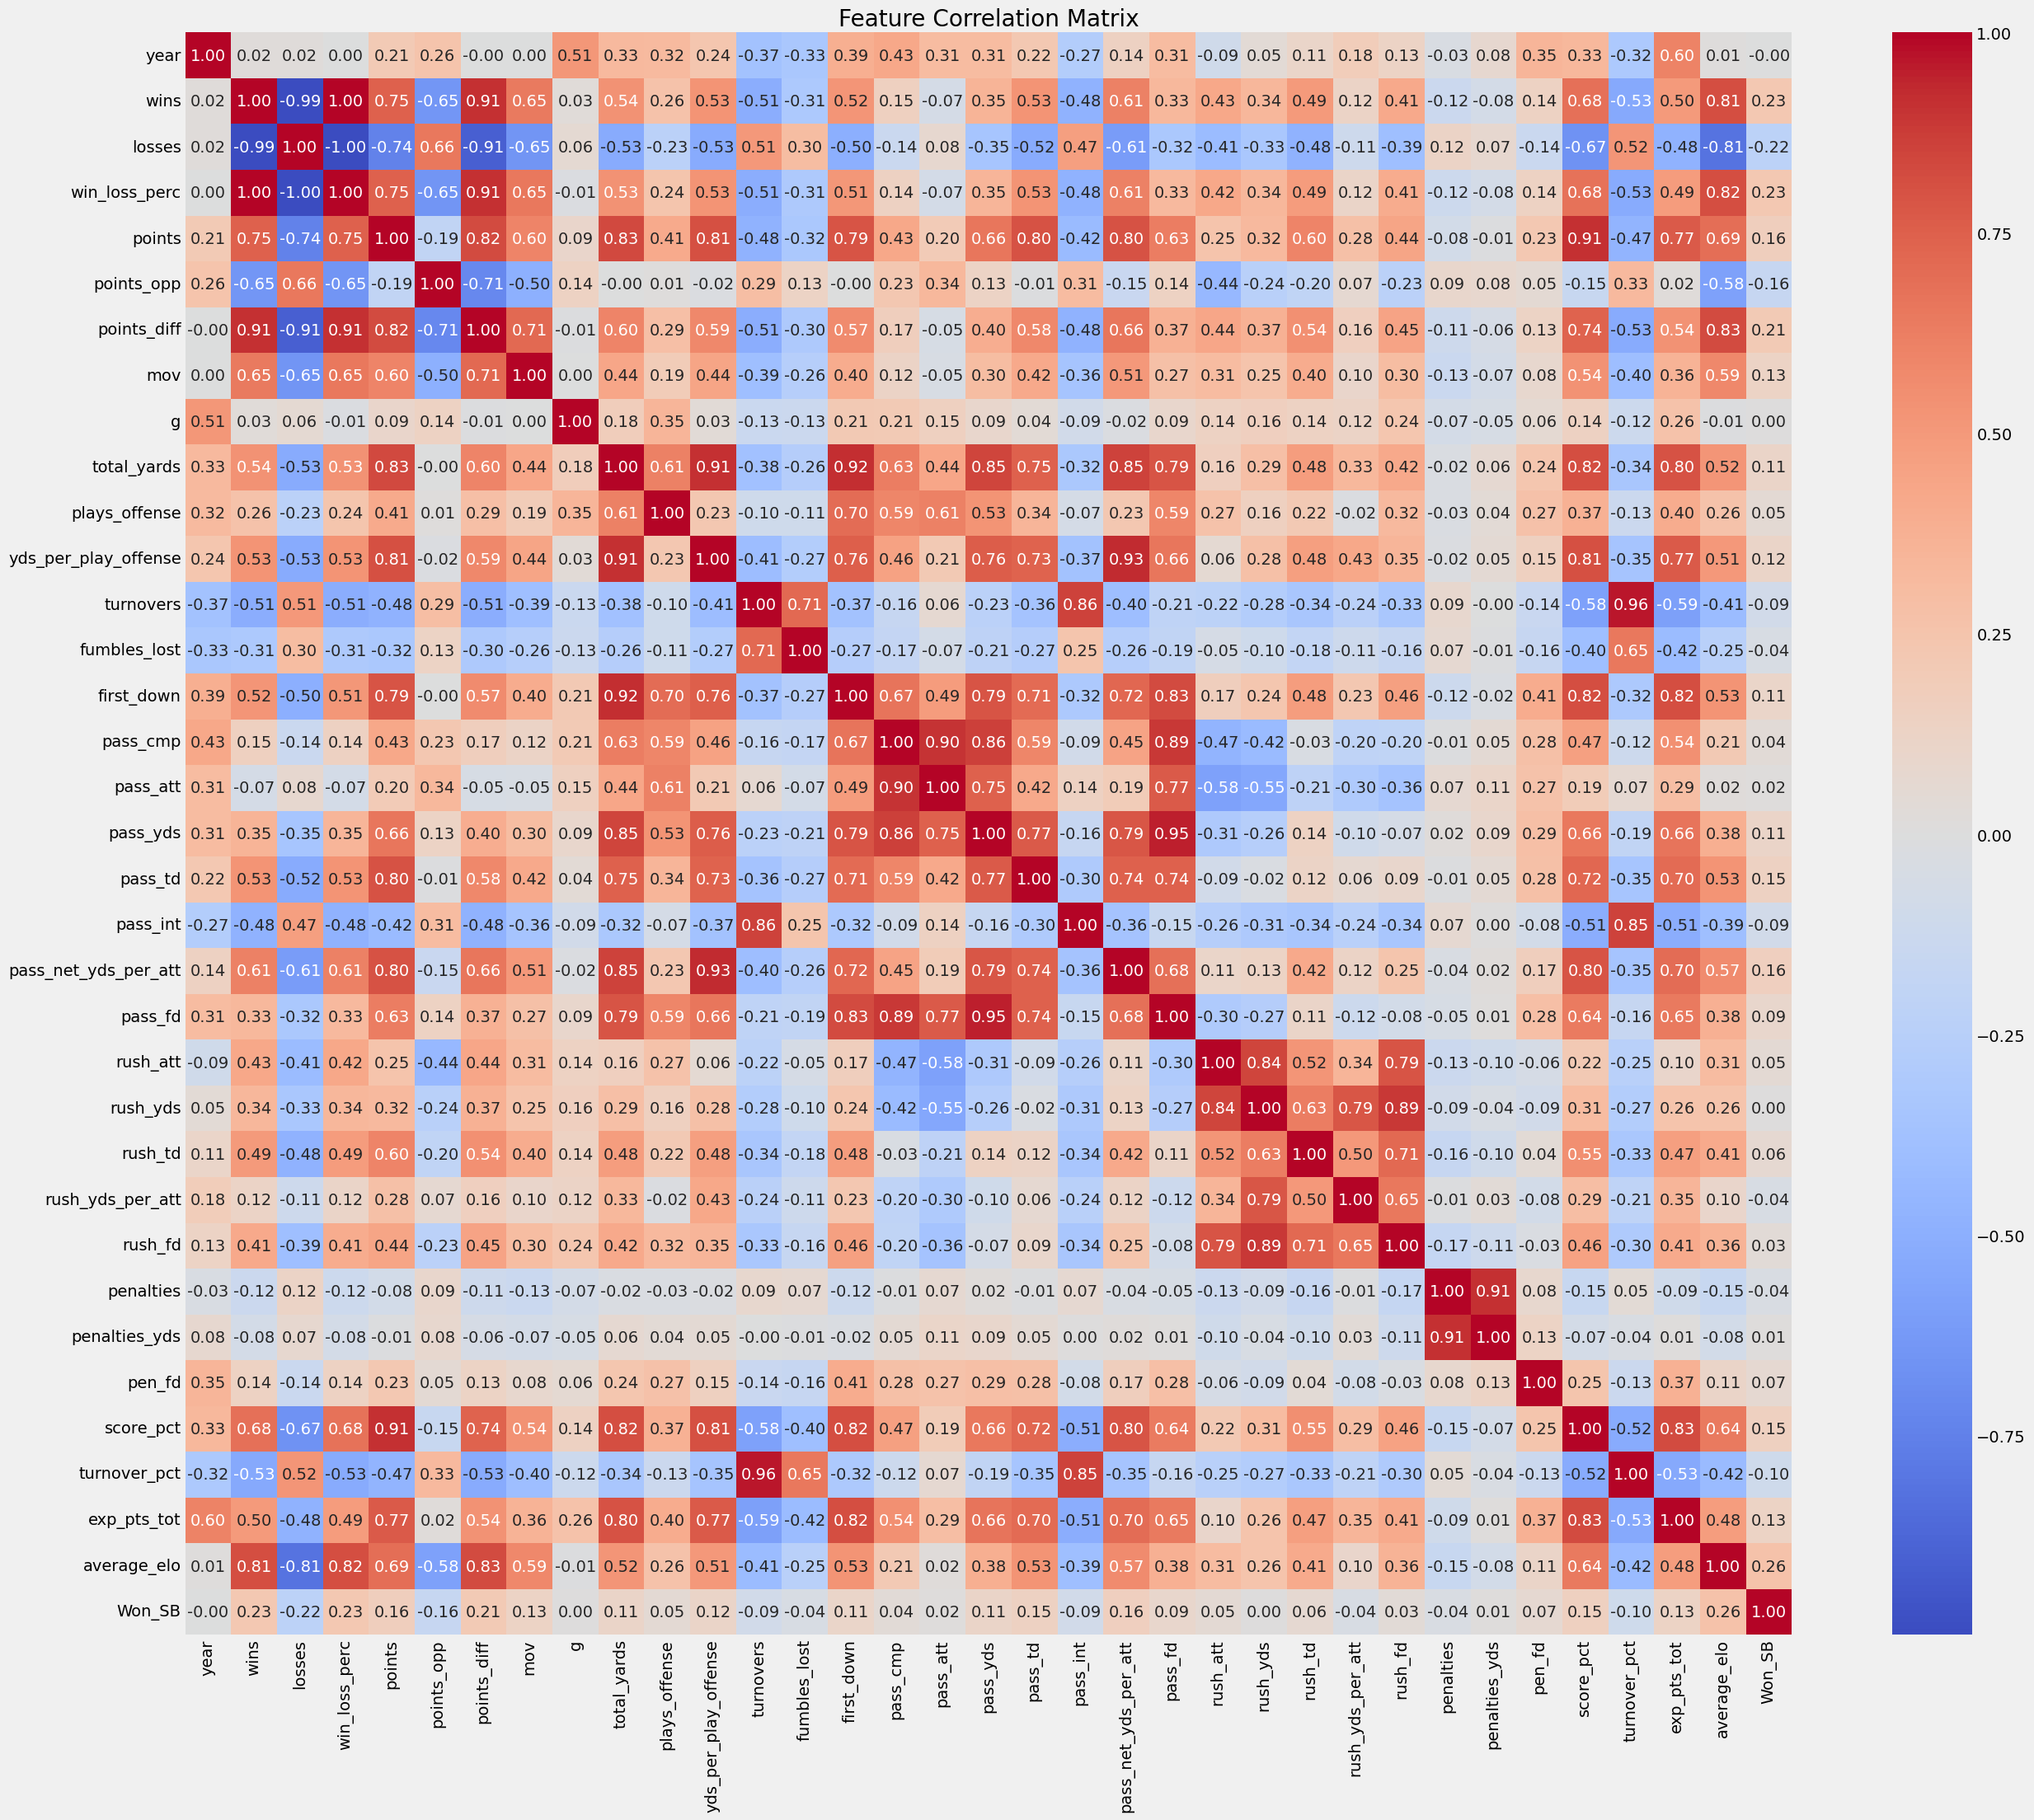

In [19]:
statistics = team_statistics.drop('team', axis=1)
plt.figure(figsize=(28, 24))
sns.heatmap(statistics.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

## Adjustment

Due to the high dimensionality of the dataset, we decided to pick out some of the most influential features and aggregate them together, creating an offensive rank and defensive rank that could be used to compare teams based on aggregated ranks of some important statistics. These were also cross-checked with some official ranking sources to prove that the ranks were reasonably assigned. There is actually no set way to decide rankings as a multitude of sources use differing methods to weigh and balance ranks. At its core, the most important features are the the total yards and points scored and allowed. This way we get offensive rank, defensive rank, and a final overall rank.

In [20]:
# Define a list of features that represent offensive performance metrics.
offensive_features = ['total_yards', 'yds_per_play_offense', 'pass_cmp', 'pass_td', 'rush_td', 'pass_net_yds_per_att', 'mov']

# Define a list of features that represent defensive performance metrics.
defensive_features = ['points_opp', 'penalties_yds', 'pen_fd']

# Aggregate the team statistics by calculating the mean for offensive and defensive features for each team and year.
team_statistics_agg = team_statistics.groupby(['year', 'team'])[offensive_features + defensive_features].mean().reset_index()

# Calculate the offensive rank for each team by summing their ranks across all offensive features within each year.
team_statistics_agg['offensive_rank'] = team_statistics_agg.groupby('year')[offensive_features].rank(method='average', axis=0).sum(axis=1)

# Calculate the defensive rank for each team by summing their ranks across all defensive features within each year.
team_statistics_agg['defensive_rank'] = team_statistics_agg.groupby('year')[defensive_features].rank(method='average', axis=0).sum(axis=1)

# Compute an overall rank by averaging the offensive and defensive ranks for each team.
team_statistics_agg['overall_rank'] = team_statistics_agg[['offensive_rank', 'defensive_rank']].mean(axis=1)

# Assign a final rank for each team within each year by ranking the overall rank values in descending order.
team_statistics_agg['final_rank'] = team_statistics_agg.groupby('year')['overall_rank'].rank(method='min', ascending=False).astype(int)

# Merge the calculated ranks (offensive, defensive, and final) back into the main team statistics DataFrame based on year and team.
team_statistics = team_statistics.merge(
    team_statistics_agg[['year', 'team', 'offensive_rank', 'defensive_rank', 'final_rank']],
    on=['year', 'team'],
    how='left'
)


/var/folders/4k/xb9s62bj17d5cs3n4n0h4np40000gn/T/ipykernel_21723/1699322996.py:11: FutureWarning: The 'axis' keyword in DataFrameGroupBy.rank is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  team_statistics_agg['offensive_rank'] = team_statistics_agg.groupby('year')[offensive_features].rank(method='average', axis=0).sum(axis=1)
/var/folders/4k/xb9s62bj17d5cs3n4n0h4np40000gn/T/ipykernel_21723/1699322996.py:14: FutureWarning: The 'axis' keyword in DataFrameGroupBy.rank is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  team_statistics_agg['defensive_rank'] = team_statistics_agg.groupby('year')[defensive_features].rank(method='average', axis=0).sum(axis=1)


Here we select win/loss percentage, offensive rank, defensive rank, average elo, and final rank as features for our ML model. The target feature is predicting a Super Bowl win.

In [21]:
features = ['win_loss_perc', 'offensive_rank', 'defensive_rank', 'average_elo', 'final_rank']
X = team_statistics[features]
y = team_statistics['Won_SB']

# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a StandardScaler to normalize the feature values.
# This ensures that all features have a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()

# Fit the scaler on the training data and transform it.
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data for the training.
X_test_scaled = scaler.transform(X_test)


Here we choose to test out a multitude of models for our accuracy and training. Here, we do want to point out that while we do try the four standard models, we are mostly looking at the linear regression since we are trying to determine probability of teams winning the Super Bowl.

In [22]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    # Balanced class weights so that the model penalizes more for incorrect predictions considering Super Bowl win probability is low.
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "KNN": KNeighborsClassifier()
}

# Test each of the model's accuracy scores.
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.9766
Decision Tree Accuracy: 0.9453
Random Forest Accuracy: 0.9766
KNN Accuracy: 0.9766


While our results are very accurate, we do want to consider the very skewed dataset. Each year 31/32 teams do not win the Super Bowl, so if the model consistently predicts each team doesn't win the Super Bowl, then it would maintain an accuracy score as high as the one we're looking at. However, we so far see that the Logistic Regression has the best accuracy though all are abover 95%.

In turn, we run a classification report to gain insight on the recall and precision of each model. We also use SMOTE to oversample the minority class of winning a Super Bowl as a means of trying to make up for the class imbalance.

One of the main reasons we use SMOTE is because, through multiple trials, we saw that without using SMOTE we actually get 0 for all precision and recall categories. However, while it does slightly reduce accuracy, it in crease precision and recall to non-zero values for the Logistic Regression that we aim to use.

While we have high accuracy, a lot of the time the models, especially Random Forest, Decision Tree and KNN, struggle with precision and recall because the model is so heavily skewed towards the result of not winning since only one winner occurs each year. A large reason is due to these models overfitting to the specific scenarios that relate to being a Super Bowl champion. While the Logistic Regression lost some accuracy, it is the only model that has a greater support of precision/recall and thus is the one we use.

In [23]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "KNN": KNeighborsClassifier()
}

for model_name, model in models.items():
    
    # Apply SMOTE resampling for all non-KNN models.
    if model_name != "KNN":
        X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_scaled, y_train)
        model.fit(X_train_resampled, y_train_resampled)
    else:
        model.fit(X_train_scaled, y_train)

# Run a similar accuracy check as prior with this one also including classification reports that describe recall and precision.
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy of {model_name}: {accuracy:.2f}")
    print(classification_report(y_test, y_pred, zero_division=0)) 

Evaluating Logistic Regression...
Accuracy of Logistic Regression: 0.84
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       125
           1       0.05      0.33      0.09         3

    accuracy                           0.84       128
   macro avg       0.52      0.59      0.50       128
weighted avg       0.96      0.84      0.89       128

Evaluating Decision Tree...
Accuracy of Decision Tree: 0.91
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       125
           1       0.00      0.00      0.00         3

    accuracy                           0.91       128
   macro avg       0.49      0.47      0.48       128
weighted avg       0.95      0.91      0.93       128

Evaluating Random Forest...
Accuracy of Random Forest: 0.93
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       125
           1       0.00      0.00      0.00  

However, here we removed the SMOTE. While the recall and precision had been improved, the overall f1-score was lower. After many trials we also had notice that the resulting probabilities were unrealistic with SMOTE, and that was mainly due to overfitting caused by SMOTE's oversampling of the minor class. Thus, we decided to drop it, despite a damage to precision and recall.

Just to compare:

SMOTE f1-score:

Accuracy: 84%
Macro Avg: 50%
Weighted Avg: 89%

Without SMOTE f1-score:

Accuracy: 98%
Macro Avg: 48%
Weighted Avg: 96%

Finally, we apply a gridsearch to optimize hyperparameters, finding the best parameters for the model to predict off of. We use a log loss scoring to make a larger difference in win percentage between teams when considering the worst teams should have nearly a 0% chance as they are out of playoff contention.

In [24]:
model = LogisticRegression(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['saga'],
    'max_iter': [500, 1000, 2000],
}

# Perform GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='neg_log_loss',
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Custom Score: {grid_search.best_score_:.4f}")

# Retrieve the best model from grid search
best_model = grid_search.best_estimator_

# Perform cross-validation with the best model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores):.4f}")

y_test_pred = best_model.predict(X_test_scaled)

print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred))



Best Parameters: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Best Custom Score: -0.1091
Cross-Validation Scores: [-0.11545661 -0.14374006 -0.08843394 -0.10700366 -0.09070605]
Mean Cross-Validation Score: -0.1091
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       125
           1       0.00      0.00      0.00         3

    accuracy                           0.98       128
   macro avg       0.49      0.50      0.49       128
weighted avg       0.95      0.98      0.96       128



/Users/justinzhai/Code/personal/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/justinzhai/Code/personal/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/justinzhai/Code/personal/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Here we print the feature importances to examine if we should drop any features. We realize that the final rank negatively effects the prediction model and the offensive rank has no/negligible effect so we remove them, reducing dimensionality once again.

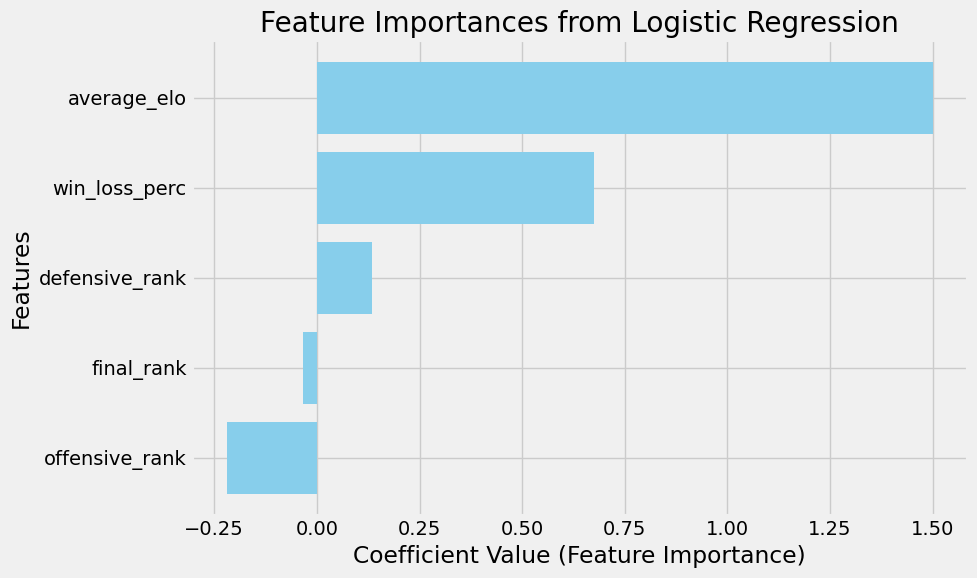

In [25]:
# We use a bar chart here to compare how important each feature is
coefficients = best_model.coef_.flatten()
feature_names = X_train.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Coefficient Value (Feature Importance)')
plt.ylabel('Features')
plt.title('Feature Importances from Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


We therefore remove final_rank and offensive_rank as features and then rerun gridsearch on the model, finding the parameters that now fit our updated model.

In [26]:
features = ['win_loss_perc', 'defensive_rank', 'average_elo']
X = team_statistics[features]
y = team_statistics['Won_SB']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
model = LogisticRegression(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000],
}

# Perform GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='neg_log_loss',
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Custom Score: {grid_search.best_score_:.4f}")

# Retrieve the best model from grid search
best_model = grid_search.best_estimator_

# Perform cross-validation with the best model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores):.4f}")

y_test_pred = best_model.predict(X_test_scaled)

print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred))


Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best Custom Score: -0.1043
Cross-Validation Scores: [-0.11071724 -0.13765098 -0.07980024 -0.10228625 -0.09082064]
Mean Cross-Validation Score: -0.1043
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       125
           1       0.00      0.00      0.00         3

    accuracy                           0.98       128
   macro avg       0.49      0.50      0.49       128
weighted avg       0.95      0.98      0.96       128



/Users/justinzhai/Code/personal/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/justinzhai/Code/personal/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/justinzhai/Code/personal/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Lastly, we import the csv of the current elo and ratings to test them on our model and achieve the probability results that we're looking for.

[Text(5, 0, '0.01%'),
 Text(5, 0, '0.04%'),
 Text(5, 0, '0.06%'),
 Text(5, 0, '0.08%'),
 Text(5, 0, '0.08%'),
 Text(5, 0, '0.08%'),
 Text(5, 0, '0.10%'),
 Text(5, 0, '0.11%'),
 Text(5, 0, '0.18%'),
 Text(5, 0, '0.24%'),
 Text(5, 0, '0.27%'),
 Text(5, 0, '0.28%'),
 Text(5, 0, '0.34%'),
 Text(5, 0, '0.46%'),
 Text(5, 0, '0.56%'),
 Text(5, 0, '0.60%'),
 Text(5, 0, '0.68%'),
 Text(5, 0, '0.83%'),
 Text(5, 0, '0.86%'),
 Text(5, 0, '1.41%'),
 Text(5, 0, '1.44%'),
 Text(5, 0, '2.07%'),
 Text(5, 0, '2.32%'),
 Text(5, 0, '2.62%'),
 Text(5, 0, '2.66%'),
 Text(5, 0, '2.78%'),
 Text(5, 0, '5.95%'),
 Text(5, 0, '7.70%'),
 Text(5, 0, '13.57%'),
 Text(5, 0, '13.57%'),
 Text(5, 0, '13.89%'),
 Text(5, 0, '14.16%')]

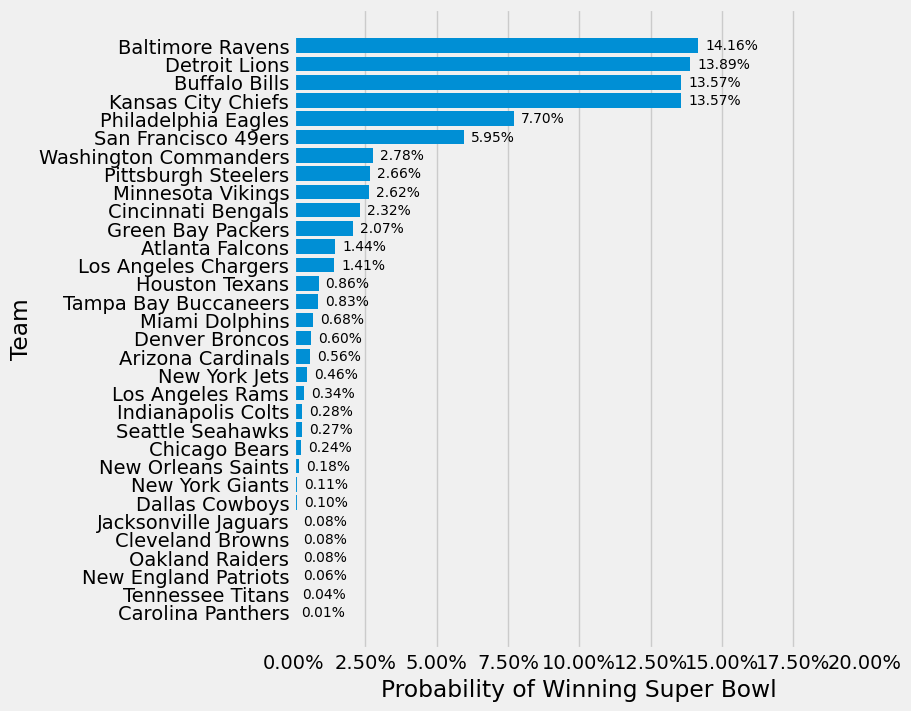

In [28]:
import matplotlib.ticker as mtick
nfl_elo_curr_df = pd.read_csv('nfl_elo_current.csv')
nfl_elo_curr_df['expected_wins'] = nfl_elo_curr_df['wins'] + (17 - nfl_elo_curr_df['week']) * (nfl_elo_curr_df['expected_wins_538_ytd']/nfl_elo_curr_df['week'])
nfl_elo_curr_df['win_loss_perc'] = nfl_elo_curr_df['expected_wins'] / 17
nfl_elo_curr_df['team'] = nfl_elo_curr_df['team'].apply(lambda team: team_name_mapping.get(team, team))
# Rename elo of the team at current to average_elo for the model
nfl_elo_curr_df.rename(columns={'nfelo': 'average_elo'}, inplace=True)

features_for_model = ['win_loss_perc', 'defensive_rank', 'average_elo']
X_curr = nfl_elo_curr_df[features_for_model]

X_curr_scaled = scaler.transform(X_curr)

nfl_elo_curr_df['super_bowl_win_prob'] = best_model.predict_proba(X_curr_scaled)[:, 1]
nfl_elo_curr_df['super_bowl_win_prob'] = round(nfl_elo_curr_df['super_bowl_win_prob'] * 100, 2)
nfl_elo_curr_df = nfl_elo_curr_df.sort_values(by='super_bowl_win_prob', ascending=True)

fig, ax = plt.subplots(figsize=(9, 7), layout='constrained')
rects = ax.barh(nfl_elo_curr_df['team'] , nfl_elo_curr_df['super_bowl_win_prob'])
ax.set_xlim(0,20)
ax.grid(axis='y') 
ax.set_xlabel('Probability of Winning Super Bowl')
ax.set_ylabel('Team')
fmt = '%.2f%%' 
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
ax.bar_label(rects, fmt=fmt,
                  padding=5, color='black', fontsize=10)



From the logistics regression, we can see that the Baltimore Ravens is the favorite to win the Super Bowl, with a 14.16% chance. The Kansas City Chiefs, is a contender as well, with the model giving it a 13.57% to win the Super Bowl. At a glance, the model appears to be since it does not give any team a particular high probability of winning the Super Bowl. However, the unpredictable nature of the playoffs make it virtually impossible to say any team will win the Super Bowl with any sort of certainty. 

If we look at the [betting odds](https://www.si.com/betting/nfl-power-rankings-based-super-bowl-odds-ahead-week-10-lions-bills-keep-climbing) at the time the data was extracted, The Chiefs were the favorites at +400, which translates to a 20% implied probability. So we can see that the model is performing realisticly when compared to Vegas odds. 

Overall, the model produces a result that is close to what the experts and Vegas says. The model does believe the Ravens are better than what people give them credit for so we will see how they do in the playoffs.